In [7]:
"""
Created on 20 dec. 2010

This file illustrated the use of the workbench for a model
specified in Python itself. The example is based on `Pruyt & Hamarat <https://www.systemdynamics.org/conferences/2010/proceed/papers/P1253.pdf>`_.
For comparison, run both this model and the flu_vensim_no_policy_example.py and
compare the results.


.. codeauthor:: jhkwakkel <j.h.kwakkel (at) tudelft (dot) nl>
                chamarat <c.hamarat  (at) tudelft (dot) nl>

"""

import matplotlib.pyplot as plt
import numpy as np
from numpy import sin, min, exp

from ema_workbench import Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator
from ema_workbench.analysis import lines, Density

# =============================================================================
#
#    the model itself
#
# =============================================================================

FINAL_TIME = 24 # 48
INITIAL_TIME = 0
TIME_STEP = 0.0078125

switch_regions = 1.0
switch_immunity = 1.0
switch_deaths = 1.0
switch_immunity_cap = 1.0


def LookupFunctionX(variable, start, end, step, skew, growth, v=0.5):
    return start + ((end - start) / ((1 + skew * exp(-growth * (variable - step))) ** (1 / v)))


def flu_model(
    x11=0,
    x12=0,
    x21=0,
    x22=0,
    x31=0,
    x32=0,
    x41=0,
    x51=0,
    x52=0,
    x61=0,
    x62=0,
    x81=0,
    x82=0,
    x91=0,
    x92=0,
    x101=0,
    x102=0,
):
    # Assigning initial values
    additional_seasonal_immune_population_fraction_R1 = float(x11)
    additional_seasonal_immune_population_fraction_R2 = float(x12)

    fatality_rate_region_1 = float(x21)
    fatality_rate_region_2 = float(x22)

    initial_immune_fraction_of_the_population_of_region_1 = float(x31)
    initial_immune_fraction_of_the_population_of_region_2 = float(x32)

    normal_interregional_contact_rate = float(x41)
    interregional_contact_rate = switch_regions * normal_interregional_contact_rate

    permanent_immune_population_fraction_R1 = float(x51)
    permanent_immune_population_fraction_R2 = float(x52)

    recovery_time_region_1 = float(x61)
    recovery_time_region_2 = float(x62)

    susceptible_to_immune_population_delay_time_region_1 = 1
    susceptible_to_immune_population_delay_time_region_2 = 1

    root_contact_rate_region_1 = float(x81)
    root_contact_rate_region_2 = float(x82)

    infection_rate_region_1 = float(x91)
    infection_rate_region_2 = float(x92)

    normal_contact_rate_region_1 = float(x101)
    normal_contact_rate_region_2 = float(x102)

    ######
    susceptible_to_immune_population_flow_region_1 = 0.0
    susceptible_to_immune_population_flow_region_2 = 0.0
    ######

    initial_value_population_region_1 = 6.0 * 10**8
    initial_value_population_region_2 = 3.0 * 10**9

    initial_value_infected_population_region_1 = 10.0
    initial_value_infected_population_region_2 = 10.0

    initial_value_immune_population_region_1 = (
        switch_immunity
        * initial_immune_fraction_of_the_population_of_region_1
        * initial_value_population_region_1
    )
    initial_value_immune_population_region_2 = (
        switch_immunity
        * initial_immune_fraction_of_the_population_of_region_2
        * initial_value_population_region_2
    )

    initial_value_susceptible_population_region_1 = (
        initial_value_population_region_1 - initial_value_immune_population_region_1
    )
    initial_value_susceptible_population_region_2 = (
        initial_value_population_region_2 - initial_value_immune_population_region_2
    )

    recovered_population_region_1 = 0.0
    recovered_population_region_2 = 0.0

    infected_population_region_1 = initial_value_infected_population_region_1
    infected_population_region_2 = initial_value_infected_population_region_2

    susceptible_population_region_1 = initial_value_susceptible_population_region_1
    susceptible_population_region_2 = initial_value_susceptible_population_region_2

    immune_population_region_1 = initial_value_immune_population_region_1
    immune_population_region_2 = initial_value_immune_population_region_2

    deceased_population_region_1 = [0.0]
    deceased_population_region_2 = [0.0]
    runTime = [INITIAL_TIME]

    # --End of Initialization--

    Max_infected = 0.0

    for time in range(int(INITIAL_TIME / TIME_STEP), int(FINAL_TIME / TIME_STEP)):
        runTime.append(runTime[-1] + TIME_STEP)
        total_population_region_1 = (
            infected_population_region_1
            + recovered_population_region_1
            + susceptible_population_region_1
            + immune_population_region_1
        )
        total_population_region_2 = (
            infected_population_region_2
            + recovered_population_region_2
            + susceptible_population_region_2
            + immune_population_region_2
        )

        infected_population_region_1 = max(0, infected_population_region_1)
        infected_population_region_2 = max(0, infected_population_region_2)

        infected_fraction_region_1 = infected_population_region_1 / total_population_region_1
        infected_fraction_region_2 = infected_population_region_2 / total_population_region_2

        impact_infected_population_on_contact_rate_region_1 = 1 - (
            infected_fraction_region_1 ** (1 / root_contact_rate_region_1)
        )
        impact_infected_population_on_contact_rate_region_2 = 1 - (
            infected_fraction_region_2 ** (1 / root_contact_rate_region_2)
        )

        #        if ((time*TIME_STEP) >= 4) and ((time*TIME_STEP)<=10):
        #            normal_contact_rate_region_1 = float(x101)*(1 - 0.5)
        #        else:normal_contact_rate_region_1 = float(x101)

        normal_contact_rate_region_1 = float(x101) * (
            1 - LookupFunctionX(infected_fraction_region_1, 0, 1, 0.15, 0.75, 15)
        )

        contact_rate_region_1 = (
            normal_contact_rate_region_1 * impact_infected_population_on_contact_rate_region_1
        )
        contact_rate_region_2 = (
            normal_contact_rate_region_2 * impact_infected_population_on_contact_rate_region_2
        )

        recoveries_region_1 = (
            (1 - (fatality_rate_region_1 * switch_deaths))
            * infected_population_region_1
            / recovery_time_region_1
        )
        recoveries_region_2 = (
            (1 - (fatality_rate_region_2 * switch_deaths))
            * infected_population_region_2
            / recovery_time_region_2
        )

        flu_deaths_region_1 = (
            fatality_rate_region_1
            * switch_deaths
            * infected_population_region_1
            / recovery_time_region_1
        )
        flu_deaths_region_2 = (
            fatality_rate_region_2
            * switch_deaths
            * infected_population_region_2
            / recovery_time_region_2
        )

        infections_region_1 = (
            susceptible_population_region_1
            * contact_rate_region_1
            * infection_rate_region_1
            * infected_fraction_region_1
        ) + (
            susceptible_population_region_1
            * interregional_contact_rate
            * infection_rate_region_1
            * infected_fraction_region_2
        )
        infections_region_2 = (
            susceptible_population_region_2
            * contact_rate_region_2
            * infection_rate_region_2
            * infected_fraction_region_2
        ) + (
            susceptible_population_region_2
            * interregional_contact_rate
            * infection_rate_region_2
            * infected_fraction_region_1
        )

        infected_population_region_1_NEXT = infected_population_region_1 + (
            TIME_STEP * (infections_region_1 - flu_deaths_region_1 - recoveries_region_1)
        )
        infected_population_region_2_NEXT = infected_population_region_2 + (
            TIME_STEP * (infections_region_2 - flu_deaths_region_2 - recoveries_region_2)
        )

        if infected_population_region_1_NEXT < 0 or infected_population_region_2_NEXT < 0:
            pass

        recovered_population_region_1_NEXT = recovered_population_region_1 + (
            TIME_STEP * recoveries_region_1
        )
        recovered_population_region_2_NEXT = recovered_population_region_2 + (
            TIME_STEP * recoveries_region_2
        )

        if fatality_rate_region_1 >= 0.025:
            qw = 1.0
        elif fatality_rate_region_1 >= 0.01:
            qw = 0.8
        elif fatality_rate_region_1 >= 0.001:
            qw = 0.6
        elif fatality_rate_region_1 >= 0.0001:
            qw = 0.4
        else:
            qw = 0.2

        if (time * TIME_STEP) <= 10:
            normal_immune_population_fraction_region_1 = (
                additional_seasonal_immune_population_fraction_R1 / 2
            ) * sin(4.5 + (time * TIME_STEP / 2)) + (
                (
                    (2 * permanent_immune_population_fraction_R1)
                    + additional_seasonal_immune_population_fraction_R1
                )
                / 2
            )
        else:
            normal_immune_population_fraction_region_1 = max(
                (
                    float(qw),
                    (additional_seasonal_immune_population_fraction_R1 / 2)
                    * sin(4.5 + (time * TIME_STEP / 2))
                    + (
                        (
                            (2 * permanent_immune_population_fraction_R1)
                            + additional_seasonal_immune_population_fraction_R1
                        )
                        / 2
                    ),
                )
            )

        normal_immune_population_fraction_region_2 = switch_immunity_cap * min(
            (
                (
                    sin((time * TIME_STEP / 2) + 1.5)
                    * additional_seasonal_immune_population_fraction_R2
                    / 2
                )
                + (
                    (
                        (2 * permanent_immune_population_fraction_R2)
                        + additional_seasonal_immune_population_fraction_R2
                    )
                    / 2
                ),
                (
                    permanent_immune_population_fraction_R1
                    + additional_seasonal_immune_population_fraction_R1
                ),
            ),
        ) + (
            (1 - switch_immunity_cap)
            * (
                (
                    sin((time * TIME_STEP / 2) + 1.5)
                    * additional_seasonal_immune_population_fraction_R2
                    / 2
                )
                + (
                    (
                        (2 * permanent_immune_population_fraction_R2)
                        + additional_seasonal_immune_population_fraction_R2
                    )
                    / 2
                )
            )
        )

        normal_immune_population_region_1 = (
            normal_immune_population_fraction_region_1 * total_population_region_1
        )
        normal_immune_population_region_2 = (
            normal_immune_population_fraction_region_2 * total_population_region_2
        )

        if switch_immunity == 1:
            susminreg1_1 = (
                normal_immune_population_region_1 - immune_population_region_1
            ) / susceptible_to_immune_population_delay_time_region_1
            susminreg1_2 = (
                susceptible_population_region_1
                / susceptible_to_immune_population_delay_time_region_1
            )
            susmaxreg1 = -(
                immune_population_region_1 / susceptible_to_immune_population_delay_time_region_1
            )
            if (susmaxreg1 >= susminreg1_1) or (susmaxreg1 >= susminreg1_2):
                susceptible_to_immune_population_flow_region_1 = susmaxreg1
            elif (susminreg1_1 < susminreg1_2) and (susminreg1_1 > susmaxreg1):
                susceptible_to_immune_population_flow_region_1 = susminreg1_1
            elif (susminreg1_2 < susminreg1_1) and (susminreg1_2 > susmaxreg1):
                susceptible_to_immune_population_flow_region_1 = susminreg1_2
        else:
            susceptible_to_immune_population_flow_region_1 = 0

        if switch_immunity == 1:
            susminreg2_1 = (
                normal_immune_population_region_2 - immune_population_region_2
            ) / susceptible_to_immune_population_delay_time_region_2
            susminreg2_2 = (
                susceptible_population_region_2
                / susceptible_to_immune_population_delay_time_region_2
            )
            susmaxreg2 = -(
                immune_population_region_2 / susceptible_to_immune_population_delay_time_region_2
            )
            if (susmaxreg2 >= susminreg2_1) or (susmaxreg2 >= susminreg2_2):
                susceptible_to_immune_population_flow_region_2 = susmaxreg2
            elif (susminreg2_1 < susminreg2_2) and (susminreg2_1 > susmaxreg2):
                susceptible_to_immune_population_flow_region_2 = susminreg2_1
            elif (susminreg2_2 < susminreg2_1) and (susminreg2_2 > susmaxreg2):
                susceptible_to_immune_population_flow_region_2 = susminreg2_2
        else:
            susceptible_to_immune_population_flow_region_2 = 0

        susceptible_population_region_1_NEXT = susceptible_population_region_1 - (
            TIME_STEP * (infections_region_1 + susceptible_to_immune_population_flow_region_1)
        )
        susceptible_population_region_2_NEXT = susceptible_population_region_2 - (
            TIME_STEP * (infections_region_2 + susceptible_to_immune_population_flow_region_2)
        )

        immune_population_region_1_NEXT = immune_population_region_1 + (
            TIME_STEP * susceptible_to_immune_population_flow_region_1
        )
        immune_population_region_2_NEXT = immune_population_region_2 + (
            TIME_STEP * susceptible_to_immune_population_flow_region_2
        )

        deceased_population_region_1_NEXT = deceased_population_region_1[-1] + (
            TIME_STEP * flu_deaths_region_1
        )
        deceased_population_region_2_NEXT = deceased_population_region_2[-1] + (
            TIME_STEP * flu_deaths_region_2
        )

        # Updating integral values
        if Max_infected < (
            infected_population_region_1_NEXT
            / (
                infected_population_region_1_NEXT
                + recovered_population_region_1_NEXT
                + susceptible_population_region_1_NEXT
                + immune_population_region_1_NEXT
            )
        ):
            Max_infected = infected_population_region_1_NEXT / (
                infected_population_region_1_NEXT
                + recovered_population_region_1_NEXT
                + susceptible_population_region_1_NEXT
                + immune_population_region_1_NEXT
            )

        recovered_population_region_1 = recovered_population_region_1_NEXT
        recovered_population_region_2 = recovered_population_region_2_NEXT

        infected_population_region_1 = infected_population_region_1_NEXT
        infected_population_region_2 = infected_population_region_2_NEXT

        susceptible_population_region_1 = susceptible_population_region_1_NEXT
        susceptible_population_region_2 = susceptible_population_region_2_NEXT

        immune_population_region_1 = immune_population_region_1_NEXT
        immune_population_region_2 = immune_population_region_2_NEXT

        deceased_population_region_1.append(deceased_population_region_1_NEXT)
        deceased_population_region_2.append(deceased_population_region_2_NEXT)

        # End of main code

    return {"TIME": runTime, "deceased_population_region_1": deceased_population_region_1}


if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)

    model = Model("mexicanFlu", function=flu_model)
    model.uncertainties = [
        RealParameter("x11", 0, 0.5),
        RealParameter("x12", 0, 0.5),
        RealParameter("x21", 0.0001, 0.1),
        RealParameter("x22", 0.0001, 0.1),
        RealParameter("x31", 0, 0.5),
        RealParameter("x32", 0, 0.5),
        RealParameter("x41", 0, 0.9),
        RealParameter("x51", 0, 0.5),
        RealParameter("x52", 0, 0.5),
        RealParameter("x61", 0, 0.8),
        RealParameter("x62", 0, 0.8),
        RealParameter("x81", 1, 10),
        RealParameter("x82", 1, 10),
        RealParameter("x91", 0, 0.1),
        RealParameter("x92", 0, 0.1),
        RealParameter("x101", 0, 200),
        RealParameter("x102", 0, 200),
    ]

    model.outcomes = [TimeSeriesOutcome("TIME"), TimeSeriesOutcome("deceased_population_region_1")]

    nr_experiments = 500

    with SequentialEvaluator(model) as evaluator:
        results = perform_experiments(model, nr_experiments, evaluator=evaluator)

    print("laat")



[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
100%|████████████████████████████████████████| 500/500 [00:37<00:00, 13.21it/s]
[MainProcess/INFO] experiments finished


laat


In [8]:
experiments, outcomes = results
outcomes.keys()

dict_keys(['TIME', 'deceased_population_region_1'])

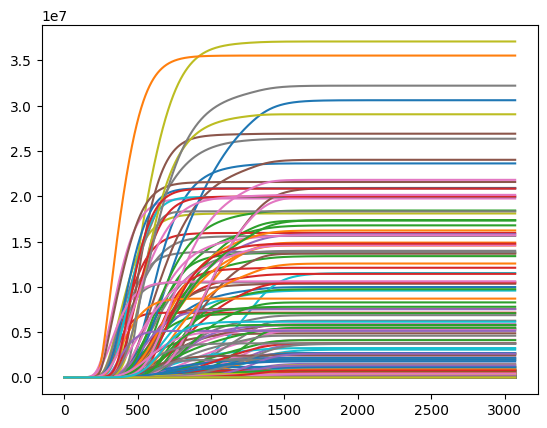

In [9]:
### plot each outcomes['deceased_population_region_1']
for i in range(0, 500):
    plt.plot(outcomes['deceased_population_region_1'][i])


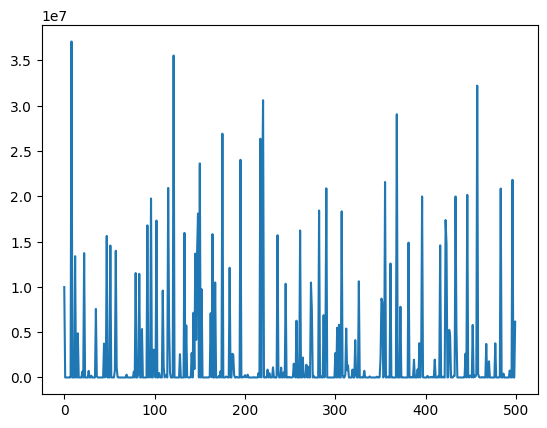

In [10]:
### get the max of each outcomes['deceased_population_region_1']
maxes = []
for i in range(0, 500):
    maxes.append(max(outcomes['deceased_population_region_1'][i]))

### plot the maxes
plt.plot(maxes)


In [11]:
### get the top five maxes indexes
top_five_maxes = sorted(range(len(maxes)), key=lambda i: maxes[i])[-5:]
top_five_maxes


[368, 220, 457, 121, 8]

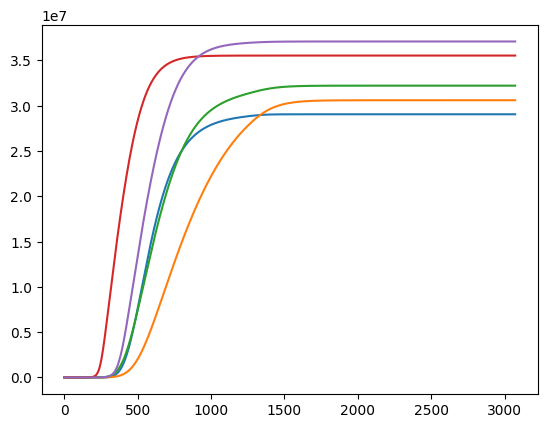

In [12]:
### plot the top five maxes outcomes['deceased_population_region_1']
for i in top_five_maxes:
    plt.plot(outcomes['deceased_population_region_1'][i])

In [24]:
from ema_workbench.analysis import prim

x = experiments
full_y = outcomes["deceased_population_region_1"] > 1000
### create an array that contains for each full_y if it contains a true value, append True
y = full_y.any(axis=1)



#y = outcomes["max_P"]


In [27]:
print(len(y), len(x))

500 500


In [29]:
y

array([ True, False, False, False, False, False,  True,  True,  True,
        True, False, False,  True,  True, False,  True, False, False,
       False, False,  True, False,  True, False, False,  True, False,
        True, False, False,  True,  True, False, False,  True,  True,
        True, False, False, False, False, False, False, False,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False,  True,  True, False,  True,  True, False, False, False,
       False, False,  True, False,  True,  True,  True, False, False,
        True,  True,  True,  True, False, False,  True,  True, False,
       False,  True,  True, False,  True,  True, False,  True,  True,
        True, False, False,  True,  True, False, False,  True, False,
       False, False,

In [21]:
experiments.head()

,x101,x102,x11,x12,x21,x22,x31,x32,x41,x51,x52,x61,x62,x81,x82,x91,x92,policy,model
0,133.566444,184.035181,0.201956,0.219718,0.048164,0.014483,0.226583,0.259433,0.509660,0.266991,0.451496,0.590576,0.769443,5.745024,3.477940,0.071468,0.099614,None,mexicanFlu
1,62.993981,36.414002,0.489403,0.280928,0.055153,0.044934,0.363012,0.042582,0.878280,0.473340,0.210734,0.064154,0.283698,8.243388,3.178600,0.098444,0.035042,None,mexicanFlu
2,19.599808,186.318392,0.069825,0.166002,0.044232,0.032269,0.090308,0.462142,0.782517,0.436985,0.035780,0.137331,0.015935,4.502705,3.052931,0.071125,0.070180,None,mexicanFlu
3,89.559258,191.806841,0.074774,0.498672,0.017680,0.033124,0.480037,0.171662,0.313993,0.099445,0.074703,0.184635,0.216592,4.068508,7.643127,0.007851,0.011603,None,mexicanFlu
4,81.538157,150.113728,0.173302,0.260573,0.087612,0.034627,0.171406,0.360537,0.763001,0.009229,0.121139,0.436022,0.160885,2.725099,6.454095,0.029966,0.064232,None,mexicanFlu


In [26]:
prim_alg = prim.Prim(x, y, threshold=1000, threshold_type=1)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


(array([13., 10., 11., 16., 26., 30., 31., 30., 37., 34.]),
 array([  0.72229465,  20.64400282,  40.56571098,  60.48741915,
         80.40912731, 100.33083548, 120.25254364, 140.17425181,
        160.09595998, 180.01766814, 199.93937631]),
 <BarContainer object of 10 artists>)

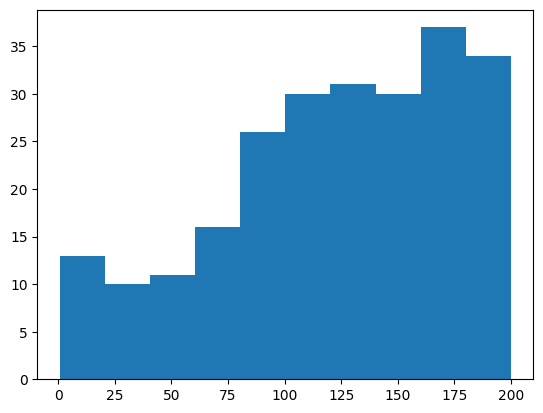

In [32]:
### get a list of indexes of y that are true
idx = []
for i in range(len(y)):
    if y[i] == True:
        idx.append(i)

#idx
### plot a histogram of experiments['x101'] that are in the idx list
plt.hist(experiments['x101'][idx])



In [55]:
### calculate the entropy of each x101 values for the idx list
from scipy.stats import entropy

### calculation the entropy of each value in experiments for the idx list
entropies = []
for i in experiments.keys():
    ### if i begins with 'x' then calculate the entropy
    if i[0] == 'x':
        entropies.append(entropy(experiments[i][idx]))

entropies

[5.358253140772632,
 5.320827831244162,
 5.261628702966508,
 5.276637631193452,
 5.277984287910872,
 5.285027857331597,
 5.285667819074363,
 5.276598013427179,
 5.290601910952724,
 5.258477601264323,
 5.294217164770536,
 5.3260603071531865,
 5.276707991954003,
 5.341652901272186,
 5.343289516008989,
 5.366837305545485,
 5.32499004510657]

In [54]:
### create a hash of the input values from experiments
hashes = []
for i in range(len(experiments)):
    hashes.append(hash(experiments.iloc[i].values.tolist().__str__()))

### print any hashes that are the same
for i in range(len(hashes)):
    for j in range(i+1, len(hashes)):
        if hashes[i] == hashes[j]:
            print(i, j)